In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
# Step 1: Read data from CSV and rename columns
data = pd.read_csv('/content/dataset.csv')

# Rename PubchemFP columns to x1, x2, x3, ..., x881
new_column_names = ['x{}'.format(i) for i in range(1, 882)]
data.columns = new_column_names + ['pIC50']  # Assuming the last column is pIC50

# Prepare data for modeling
X = data[new_column_names]  # Features
y = data['pIC50']  # Target variable

In [3]:
def AIC(y_pred,y_real,x):
    mseloss=mean_squared_error(y_pred,y_real)
    x_len=y_pred.shape[0]
    n_features=x.shape[1]

    aic=2*n_features-2*np.log(mseloss)

    return aic

def BIC(y_pred,y_real,x):
    mseloss=mean_squared_error(y_pred,y_real)
    x_len=y_pred.shape[0]
    n_features=x.shape[1]

    bic=np.log(x_len)*n_features - 2*np.log(mseloss)

    return bic

In [4]:
# Step 2: Remove low variance features
threshold_var = 0.2  # Define threshold for variance
selector = VarianceThreshold(threshold=threshold_var)
X_filtered = selector.fit_transform(X)

# Get selected feature indices and apply to original feature names
selected_feature_indices = selector.get_support(indices=True)
selected_features = X.columns[selected_feature_indices]

# Update X with filtered features
X = pd.DataFrame(X_filtered, columns=selected_features)

In [5]:
# Step 3: Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Normalize features
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

In [6]:
# Step 5: Apply Principal Component Analysis (PCA) for feature extraction
n_components = 50  # Define the number of principal components
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train_scaled)
X_val_pca = pca.transform(X_val_scaled)

In [7]:
# Step 5: Train Random Forest Regression with All Features
rf_model_all_features = RandomForestRegressor(n_estimators=200, random_state=42)  # Random Forest with 100 trees
rf_model_all_features.fit(X_train_scaled, y_train)  # Train with all features

RandomForestRegressor(n_estimators=200, random_state=42)

In [8]:
# Step 6: Train Random Forest Regression with PCA-transformed Features
rf_model_pca = RandomForestRegressor(n_estimators=200, random_state=42)  # Random Forest with 100 trees
rf_model_pca.fit(X_train_pca, y_train)  # Train with PCA-transformed features

RandomForestRegressor(n_estimators=200, random_state=42)

In [9]:
# Step 7: Evaluate Models on Validation Set
y_pred_all_features = rf_model_all_features.predict(X_val_scaled)
y_pred_pca = rf_model_pca.predict(X_val_pca)

mse_all_features = mean_squared_error(y_val, y_pred_all_features)
r2_all_features = r2_score(y_val, y_pred_all_features)
aic_all_features = AIC(y_pred_all_features, y_val, X_train_scaled)

mse_pca = mean_squared_error(y_val, y_pred_pca)
r2_pca = r2_score(y_val, y_pred_pca)
aic_pca = AIC(y_pred_pca, y_val, X_train_pca)

In [10]:
# Print PCA components and MSE values
print(f"Number of PCA Components: {n_components}")
print('Metrics for PCA Model: ')

print(f"MSE - PCA {n_components} Components (RF): {mse_pca}")
print(f"R2 - PCA {n_components} Components (RF): {r2_pca}")
print(f"AIC - PCA {n_components} Components (RF): {aic_pca}")


print('Metrics for All Features model:')
print(f"MSE - All Features (RF): {mse_all_features}")
print(f"R2 - All Features (RF): {r2_all_features}")
print(f"AIC - All Features (RF): {aic_all_features}")


Number of PCA Components: 50
Metrics for PCA Model: 
MSE - PCA 50 Components (RF): 0.825266968068234
R2 - PCA 50 Components (RF): 0.5691634920220452
AIC - PCA 50 Components (RF): 100.38409669467084
Metrics for All Features model:
MSE - All Features (RF): 0.8132186790208839
R2 - All Features (RF): 0.5754533872694219
AIC - All Features (RF): 262.4135104554339


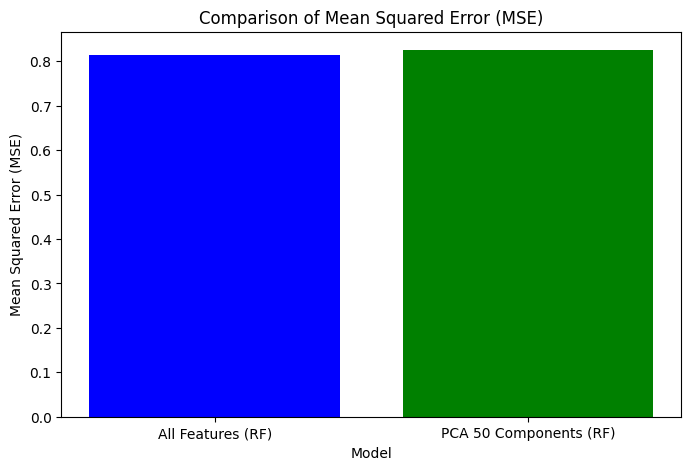

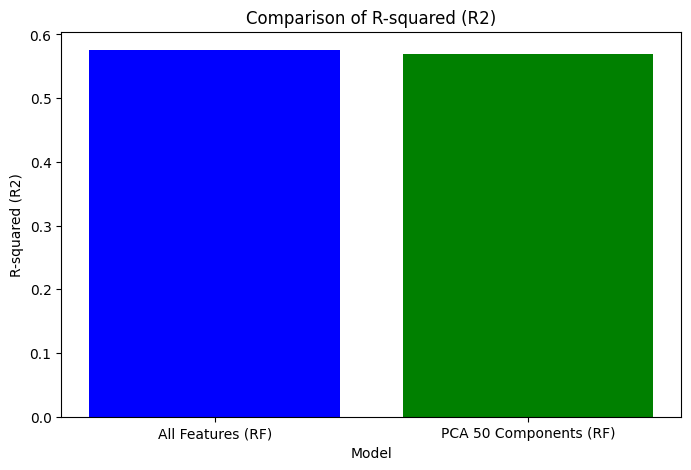

In [12]:
# Step 8: Plot Comparison of Model Performances
labels = ['All Features (RF)', f'PCA {n_components} Components (RF)']
mse_scores = [mse_all_features, mse_pca]
r2_scores = [r2_all_features, r2_pca]

# Plot MSE comparison
plt.figure(figsize=(8, 5))
plt.bar(labels, mse_scores, color=['blue', 'green'])
plt.xlabel('Model')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Comparison of Mean Squared Error (MSE)')
plt.show()

# Plot R2 comparison
plt.figure(figsize=(8, 5))
plt.bar(labels, r2_scores, color=['blue', 'green'])
plt.xlabel('Model')
plt.ylabel('R-squared (R2)')
plt.title('Comparison of R-squared (R2)')
plt.show()

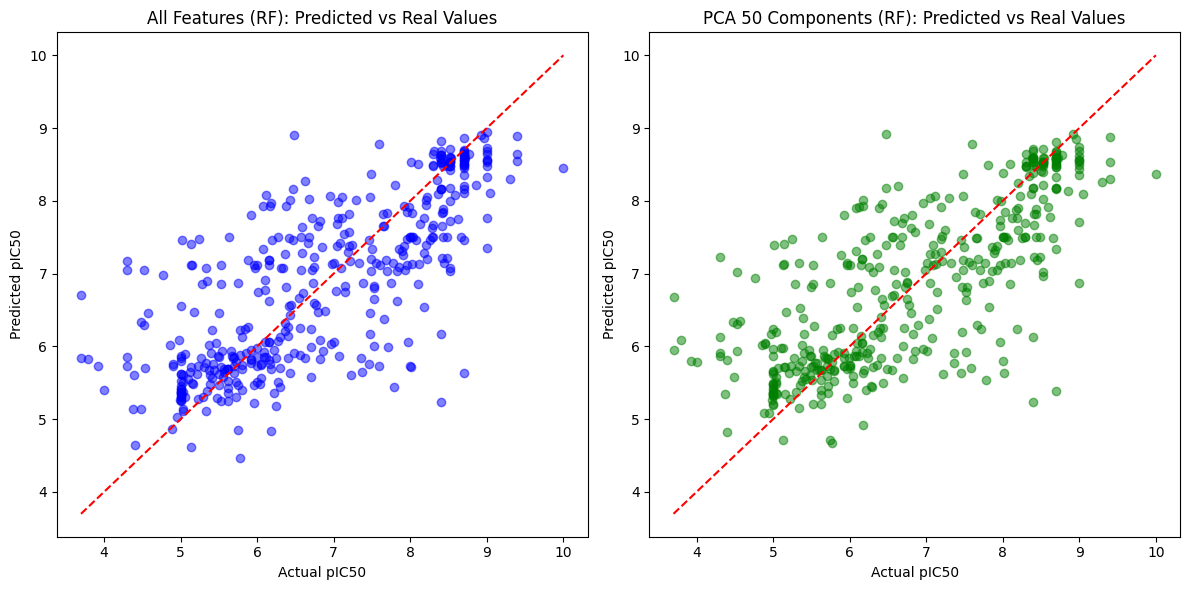

In [13]:
# Step 8: Plot Predicted vs Real Values for both models
plt.figure(figsize=(12, 6))

# Plot for All Features (RF)
plt.subplot(1, 2, 1)
plt.scatter(y_val, y_pred_all_features, color='blue', alpha=0.5)
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], color='red', linestyle='--')
plt.title('All Features (RF): Predicted vs Real Values')
plt.xlabel('Actual pIC50')
plt.ylabel('Predicted pIC50')

# Plot for PCA Components (RF)
plt.subplot(1, 2, 2)
plt.scatter(y_val, y_pred_pca, color='green', alpha=0.5)
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], color='red', linestyle='--')
plt.title(f'PCA {n_components} Components (RF): Predicted vs Real Values')
plt.xlabel('Actual pIC50')
plt.ylabel('Predicted pIC50')

plt.tight_layout()
plt.show()

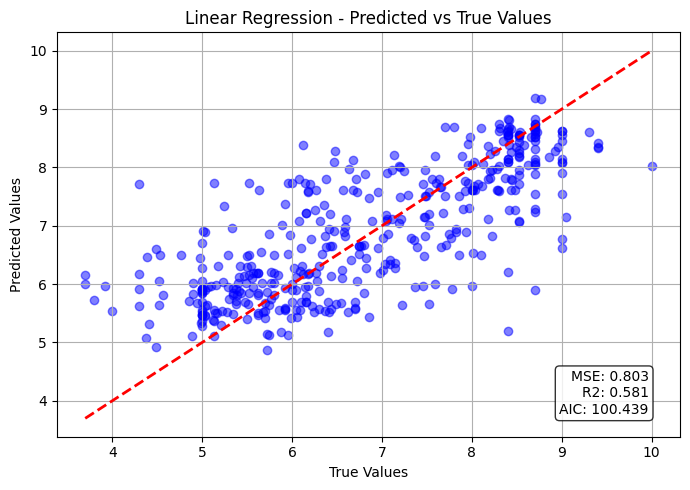

Model: Linear Regression
Mean Squared Error: 0.8027
R2 Score: 0.5809
AIC Value: 100.4395
--------------------


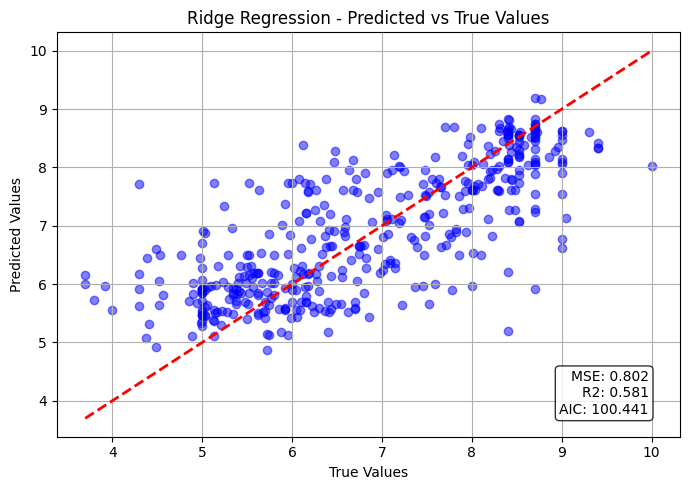

Model: Ridge Regression
Mean Squared Error: 0.8023
R2 Score: 0.5812
AIC Value: 100.4406
--------------------


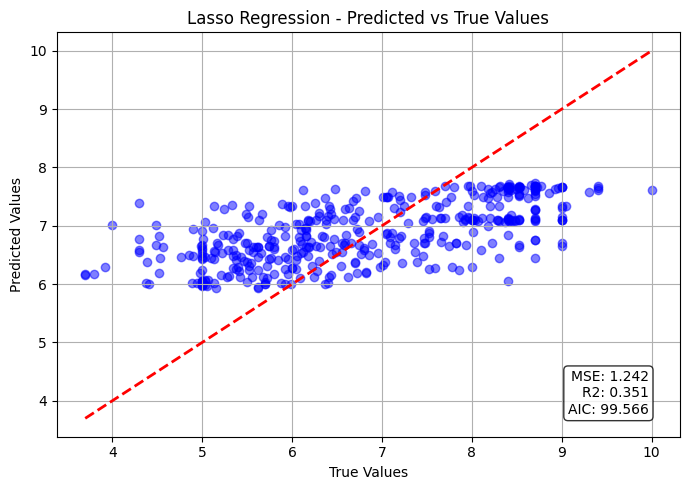

Model: Lasso Regression
Mean Squared Error: 1.2424
R2 Score: 0.3514
AIC Value: 99.5659
--------------------


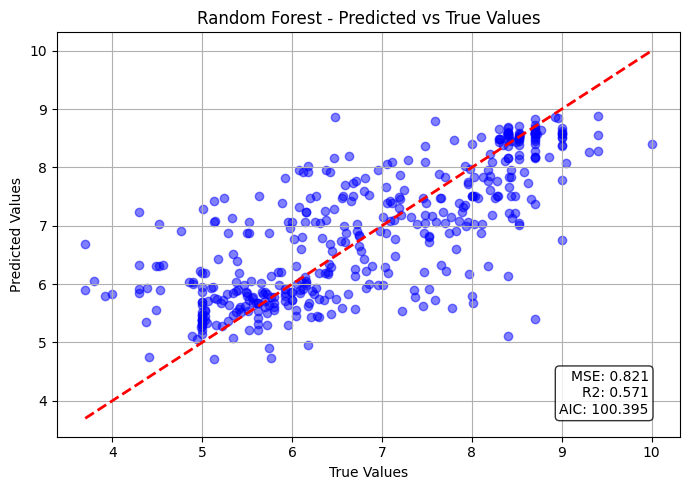

Model: Random Forest
Mean Squared Error: 0.8208
R2 Score: 0.5715
AIC Value: 100.3949
--------------------


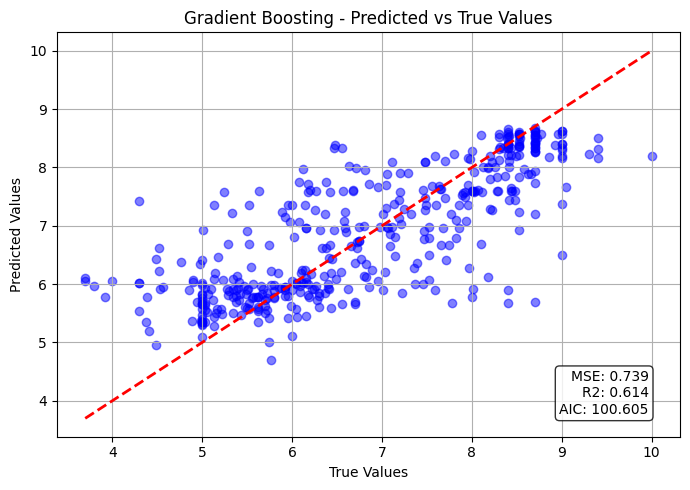

Model: Gradient Boosting
Mean Squared Error: 0.7388
R2 Score: 0.6143
AIC Value: 100.6054
--------------------


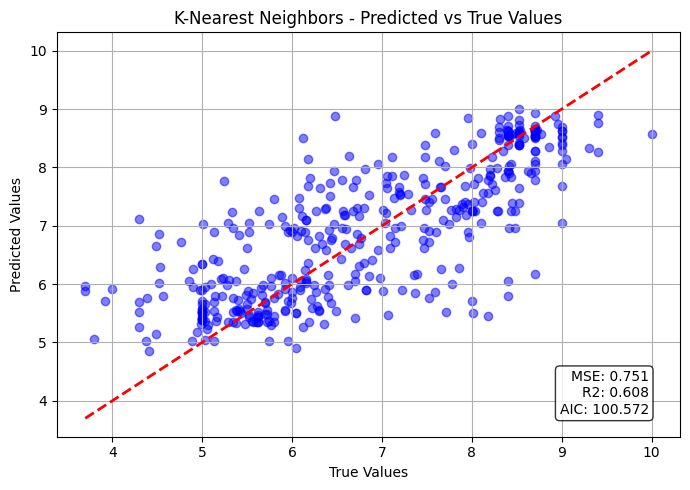

Model: K-Nearest Neighbors
Mean Squared Error: 0.7514
R2 Score: 0.6077
AIC Value: 100.5716
--------------------


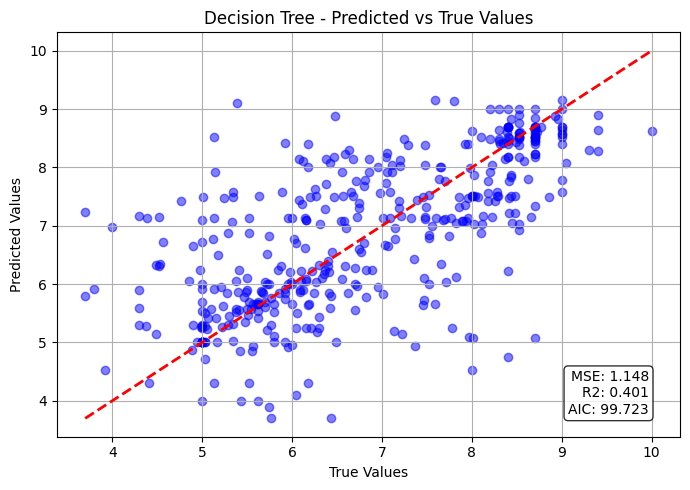

Model: Decision Tree
Mean Squared Error: 1.1483
R2 Score: 0.4005
AIC Value: 99.7234
--------------------


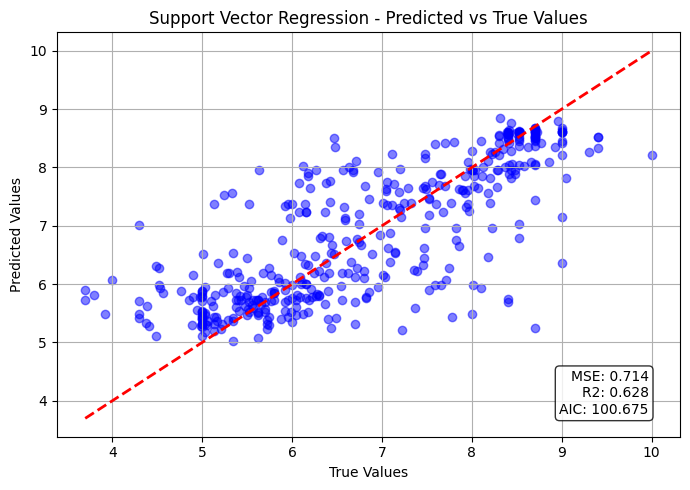

Model: Support Vector Regression
Mean Squared Error: 0.7135
R2 Score: 0.6275
AIC Value: 100.6751
--------------------


In [15]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score


X_train = X_train_pca
Y_train = y_train
X_test = X_val_pca
Y_test = y_val

# Define a list of models to evaluate
models = [
    ("Linear Regression", LinearRegression()),
    ("Ridge Regression", Ridge(alpha=1.0)),
    ("Lasso Regression", Lasso(alpha=1.0)),
    ("Random Forest", RandomForestRegressor(n_estimators=100, random_state=42)),
    ("Gradient Boosting", GradientBoostingRegressor(n_estimators=100, random_state=42)),
    ("K-Nearest Neighbors", KNeighborsRegressor(n_neighbors=5)),
    ("Decision Tree", DecisionTreeRegressor(random_state=42)),
    ("Support Vector Regression", SVR(kernel='rbf'))
]

# Iterate over each model
for name, model in models:
    # Fit the model
    model.fit(X_train, Y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Calculate evaluation metrics
    mse = mean_squared_error(Y_test, y_pred)
    r2 = r2_score(Y_test, y_pred)
    aic = AIC(y_pred, Y_test, X_train)

    # Plot predicted vs true values
    plt.figure(figsize=(7, 5))
    plt.scatter(Y_test, y_pred, color='blue', alpha=0.5)
    plt.plot([min(Y_test), max(Y_test)], [min(Y_test), max(Y_test)], '--', color='red', linewidth=2)
    plt.title(f"{name} - Predicted vs True Values")
    plt.xlabel("True Values")
    plt.ylabel("Predicted Values")
    plt.grid(True)
    plt.tight_layout()

    # Display evaluation metrics
    plt.text(0.95, 0.05, f"MSE: {mse:.3f}\nR2: {r2:.3f}\nAIC: {aic:.3f}", ha='right', va='bottom', transform=plt.gca().transAxes, fontsize=10, bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    # Save or show plot
    plt.savefig(f"{name}_test_data_predicted_vs_true.png")
    plt.show()

    # Display results
    print(f"Model: {name}")
    print(f"Mean Squared Error: {mse:.4f}")
    print(f"R2 Score: {r2:.4f}")
    print(f"AIC Value: {aic:.4f}")
    print("--------------------")
